# Import librerie

In [1]:

import os 
import time
import random
import numpy as np

# plot utilities
import matplotlib as mpl
import matplotlib.pyplot as plt #visualizzazione graph
plt.rcParams['figure.figsize'] = [15,5] # width, height

# image management
import cv2 as cv
from skimage import io, transform, filters, color

# ML
import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense
from keras.applications import vgg16, mobilenet_v2
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.preprocessing import image as kimage
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report

# Crop facce

In [55]:
#base_path = '/Users/gisto/Desktop/Digital Signal and Image Management/progetto/'
base_path = '/Users/gisto/Desktop/Digital Signal and Image Management/progetto/'

In [3]:
# sorgente (cartella immagini) #raggruppo tutte foto di una persona 
images = base_path + 'testLeo/'

In [4]:
# destinazione (dove mettere facce croppate)
cropped_faces = base_path + 'TEST/1/'

In [ ]:
#croppo facce e mando a train e test 
for fi, f in enumerate(sorted(os.listdir(images))):
    try:
        exists = os.path.exists(cropped_faces+f)

        img = cv.imread(images+f )
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_detector.detectMultiScale(img_gray)

        x,y,w,h = faces[0]

        for (x,y,w,h) in faces:
            cropped_image = img[y:y+h, x:x+w]
            plt.imshow(cropped_image[:,:,-1::-1])
            cv.imwrite(cropped_faces+ str(random.randint(0,100))+f, cropped_image)
            
    except:
        print(images+ str(random.randint(0,100))+f + 'didn\'t work')

# Allenamento modello di face recognition

In [56]:
batch_size = 32
augmentation = False

In [57]:
# funzione di preprocessing delle immagini
#anche qui niente data augmentation perchè peggiora

if augmentation:
    # con data augmentation
    data_processing = ImageDataGenerator(#preprocessing_function=mobilenet_v2.preprocess_input,
                                         horizontal_flip = True,
                                         width_shift_range = 0.2,
                                         height_shift_range = 0.2,
                                         brightness_range = (0.4,1.5),
                                         zoom_range = [0.5,1.0],
                                         rotation_range = 90)
    
else:
    # senza data augmentation
    train_processing = ImageDataGenerator(#preprocessing_function=mobilenet_v2.preprocess_input, 
                                          validation_split=0.1, rescale=1.0/255.0)
    
test_processing = ImageDataGenerator(#preprocessing_function=mobilenet_v2.preprocess_input, 
                                     rescale=1.0/255.0)

In [58]:
# import immagini

train_generator = train_processing.flow_from_directory(
    directory = base_path + 'TRAIN/',
    target_size = (224, 224),
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    subset = 'training',
    shuffle = True,
    seed = 1)

validation_generator = train_processing.flow_from_directory(
    directory = base_path + 'TRAIN/',
    target_size = (224, 224),
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    subset = 'validation',
    shuffle = True,
    seed = 1)

test_generator = test_processing.flow_from_directory(
    directory = base_path + 'TEST',
    target_size = (224, 224),
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle = False,
    seed = 1)

Found 672 images belonging to 3 classes.
Found 73 images belonging to 3 classes.
Found 83 images belonging to 3 classes.


### Modello

In [65]:
# Modello di base
base_net = vgg16.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')
# base_net = vgg16.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

In [66]:
# Congelamento del modello di base
for layer in base_net.layers:
    layer.trainable = False

In [67]:
#deefinisco struttura rete 
#aggiungo 2 layer dense e softmax alla fine (migliore dopo varie prove)
x = base_net.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
pred = Dense(3, activation='softmax')(x)

net = Model(inputs=base_net.input, outputs=pred)

In [68]:
net.compile(loss=categorical_crossentropy,
            optimizer=Adam(0.0001), # learning rate più lento
            metrics=['accuracy'])

In [69]:
#early stopping con la min di val_los
epochs = 30

early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience = 3, 
                               mode = 'min', restore_best_weights = True)

history = net.fit(train_generator, 
                  epochs = epochs,
                  validation_data = validation_generator,
                  callbacks = [early_stopping])

Epoch 1/30
21/21 [==============================] - 151s 7s/step - loss: 1.1295 - accuracy: 0.3750 - val_loss: 1.0788 - val_accuracy: 0.3562
Epoch 2/30
21/21 [==============================] - 148s 7s/step - loss: 1.1125 - accuracy: 0.3586 - val_loss: 1.0702 - val_accuracy: 0.3699
Epoch 3/30
21/21 [==============================] - 144s 7s/step - loss: 1.1044 - accuracy: 0.3780 - val_loss: 1.0517 - val_accuracy: 0.4932
Epoch 4/30
21/21 [==============================] - 255s 12s/step - loss: 1.0730 - accuracy: 0.3988 - val_loss: 1.0378 - val_accuracy: 0.5479
Epoch 5/30
21/21 [==============================] - 147s 7s/step - loss: 1.0848 - accuracy: 0.3973 - val_loss: 1.0289 - val_accuracy: 0.6986
Epoch 6/30
21/21 [==============================] - 140s 7s/step - loss: 1.0700 - accuracy: 0.4256 - val_loss: 1.0178 - val_accuracy: 0.5616
Epoch 7/30
21/21 [==============================] - 141s 7s/step - loss: 1.0546 - accuracy: 0.4375 - val_loss: 0.9994 - val_accuracy: 0.8082
Epoch 8/30
2

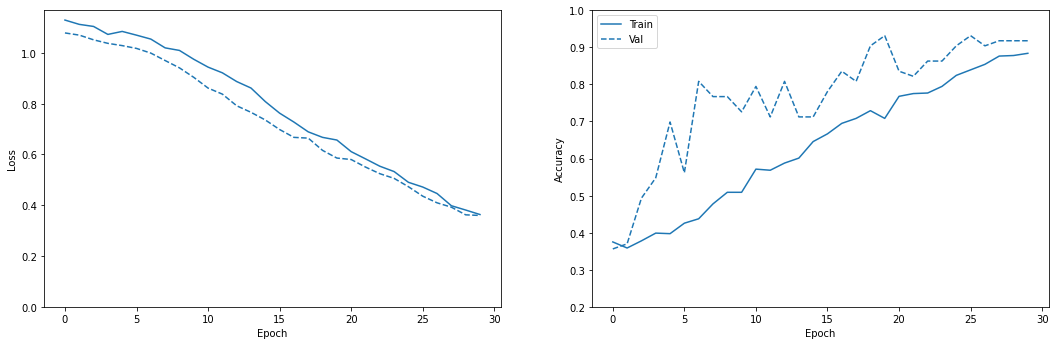

In [70]:
#plotto loss /epoche . accuracy/epoche
mpl.rcParams['figure.figsize'] = (18, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics =  ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'accuracy':
            plt.ylim([0.2,1])
        else:
            plt.ylim([0,1])

    plt.legend()


plot_metrics(history)

In [71]:
#guardo performance modello
performance = net.evaluate(test_generator)

3/3 [==============================] - 18s 6s/step - loss: 0.2135 - accuracy: 0.9639


In [72]:
true_labels=test_generator.classes
predictions=net.predict(test_generator)

In [73]:
predictions=np.array([np.argmax(x) for x in predictions])

In [74]:
print(classification_report(true_labels,predictions))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       1.00      0.94      0.97        32
           2       0.96      0.96      0.96        28

    accuracy                           0.96        83
   macro avg       0.96      0.97      0.96        83
weighted avg       0.97      0.96      0.96        83



In [75]:
# Save model
net.save("model_vgg16.h5")

# Test modello

In [2]:
net = keras.models.load_model('model_vgg16.h5')

In [22]:
#leo2 ric2
names = ['Leonardo' ,'Riccardo', 'Giacomo']

tipo = 'import'
filename = 'ric2.jpg'

In [23]:
#leo2
if tipo == 'take':
    cap = cv.VideoCapture(0)
    result, img = cap.read() # Acquisizione immagine
    cap.release() # Rilascio del dispositivo
    img = img[:,:,-1::-1] # scambio canali

elif tipo == 'import':
    img = io.imread(filename)

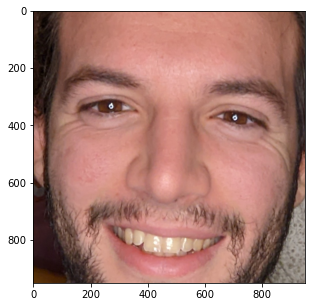

In [24]:
# Caricamento modello per il rilevamento di volti frontali
face_detector = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')

faces = face_detector.detectMultiScale(img)
#faces = faces.tolist()

for (x,y,w,h) in faces:
    face = img[y:y+h, x:x+w,]

plt.imshow(face)

In [25]:
# preprocessing immagine
img_pixels = cv.resize(face/255, (224, 224))#rifaccio il rescale 0-1
img_pixels = img_to_array(img_pixels)
img_pixels = np.expand_dims(img_pixels, axis = 0)

In [26]:
# recognition
y_pred = net.predict(img_pixels)
print(y_pred)
print(names[np.argmax(y_pred)])

[[0.01489646 0.55484396 0.4302595 ]]
Riccardo
